In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
np.random.seed(1)

In [2]:
class ganzhiqi(object): #定义分类器类
    def _init_(self):
        self.W=None      #定义分类器类初始化线性分类器的权重向量W，注意该权重向量的shape会随数据变化，所以初始化为None
    def train(self,x,y,lr=0.1,num_iters=1000):  #定义分类器类的训练接口，迭代步长0.1，迭代最大次数1000次
        num_train,num_features=x.shape         #获得特征矩阵X的两维长度 num_train 表示样本数，num_features表示特征维数
        xone=np.ones((num_train,1))          #规范化特征矩阵，在第一列补1，构成增广特征阵
        x=np.column_stack((xone,x))          #规范化特征矩阵，在第一列补1，构成增广特征阵
        x[np.where(y==-1)]=x[np.where(y==-1)]*-1  #规范化特征矩阵，使得类标为负类的样本所有特征乘以-1，注意这也包括了人工补的第一列全1
        #权重和偏置初始化
        self.W=np.random.rand(num_features+1)
        bias=0.0
        for i in range (num_iters):    
            errors=0 #所有错分样本离超平面函数距离
            for Xi,target in zip(x,y):     #组合特征和标签，这里使用了单样本增量迭代
                if(np.dot(Xi,self.W)>bias):  #如果规范化增广特征向量和权重的乘积大于自定义偏置则为正确分类的样本，无需更新权重
                    continue
                errors+=np.dot(Xi,self.W)   #把错误样本离超平面函数距离累加
                self.W+=Xi*lr               #利用错分样本进行更新权重
            
            if errors==0:                  #终止条件1：无错分样本，则不再更新权重
                print('no wrong sample break')
                break
    
    def linear(self,x):                    #内置方法，计算样本与超平面函数距离
        return np.dot(x,self.W[1:])+self.W[0]
    
    def predict(self,x):                 #预测接口，注意只有这么写才能方便调包mlxtend，只有调包才是最重要的事情！
        return np.where(self.linear(x)>=0.0,1,-1)

In [3]:
class voter(object):          #定义投票器包装类，注意这个类是出于复用考虑独立出来的，需要传入分类器，只负责投票
    def _init_(self):
        self.wmatrix=[]  #分类器权重矩阵
        self.Mode=0     #定义投票器模式 0：ovr 一对多，1：ovo 一对一
        self.classes=None
    def train(self,x,y,mode,classifier):   #训练接口，相比一般的训练多了mode参数和classifier参数
        matrix=[]                          
        self.Mode=mode 
        y=np.array(y)
        n_classes=np.unique(y)   #搜索到底有多少个类别    eg: unique([0,0,1,2,2])= [0,1,2]
        self.classes=n_classes
        if mode==0: #ovr
            self.Mode=0
            print('training use ovr vote')
            for i in n_classes:
                y_new=y              #用新的内存空间来防止误操作
                y_new=np.where(y_new==i,1,-1)      #将类标映射为目标类为正类，非目标类为负类的标准形式
                classifier.train(x,y_new)          #调用传入分类器的训练接口
                matrix.append(classifier.W)        
        else:
            if mode==1: #ovo
                self.Mode=1
                print('training use ovo vote')
                n_classes=np.unique(y)
                x=np.array(x)
                y=np.array(y)
                for i in n_classes:
                    for j in n_classes:             #类别两两组合
                        if(i>=j):
                            continue
                        y_new=y
                        y_new_i=y[np.where(y_new==i)]            #找出第i类的特征和类标
                        x_new_i=x[np.where(y_new==i)]
                        y_new_j=y[np.where(y_new==j)]            #找出第j类的特征和类标
                        x_new_j=x[np.where(y_new==j)]
                        y_new=np.concatenate((y_new_i,y_new_j),axis=0)    #第i类与第j类拼接
                        x_new=np.concatenate((x_new_i,x_new_j),axis=0)
                        y_new=np.where(y_new==i,1,-1)           #将i，j这两类映射为标准形式
                        classifier.train(x_new,y_new)          
                        matrix.append(classifier.W)
        self.wmatrix=matrix
        return matrix
    
    def predict(self,x):                                   #预测
        Wm=self.wmatrix
        vote=[]
        tim=0
        result=[]
        if self.Mode==1:                              #ovo策略的训练器进行投票
            print('using ovo mode for predicting')
            for i in self.classes:
                for j in self.classes:    #类别两两组合
                    if(i>=j):
                        continue
                    w=Wm[tim]                          
                    prediction=np.where((np.dot(x,w[1:])+w[0])>=0,i,j) #利用训练好的权重给出每个样本的类别
                    vote.append(prediction)                           #加入到投票矩阵种
                    tim+=1
            vote=np.array(vote).T                                    #投票矩阵是3*num_train的格式，所以要先做转置
            for line in vote:
                tt=np.argmax(np.bincount(line))                     #转置后是num_train*3,也就是每个样本有3个预测结果，对结果进行投票
                result.append(tt)                                   
        else:
            if self.Mode==0:
                print('using ovr mode for predicting')
                for w in self.wmatrix:
                    prediction=np.where((np.dot(x,w[1:])+w[0])>=0,1,-1)
                    vote.append(prediction)
                vote=np.array(vote).T
                for line in vote:
                    tt=np.argmax(line)                           #这里不统计出现个数是因为投票矩阵是的一行是[1,-1,-1]形式只要找到
                    result.append(tt)                            #正类出现的位置即可，对于同票的情况[1,1,-1]，直接以第一个
        return np.array(result)                                 #出现的正类的位置为最终决策，这是由于那些点往往是线性不可分点
                                                                #也就是没有更好的决策方式来说明该点属于哪一类。
        #理解一个算法最好的方式是自己实现一遍。

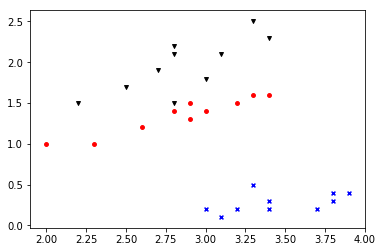

In [4]:
# x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5  
# y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5  
# h = 0.01
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
iris=load_iris()
feature=iris.data
target=iris.target
x=feature[:,[1,3]]
y=target[:]
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=31,stratify=y)
label = np.array(y_test)  
index_0 = np.where(label==0)  
plt.scatter(x_test[index_0,0],x_test[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x_test[index_1,0],x_test[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x_test[index_2,0],x_test[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

plt.show()

[ 4.617022    2.64032449 -8.69988563]


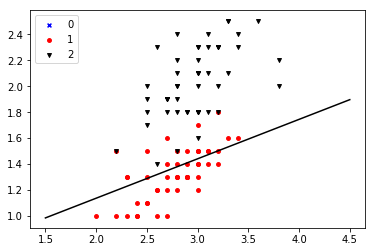

In [5]:
iris=load_iris()
feature=iris.data
target=iris.target
x=feature[50:150,[1,3]]
y=target[50:150]
label = np.array(y)  
index_0 = np.where(label==0)  
plt.scatter(x[index_0,0],x[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x[index_1,0],x[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x[index_2,0],x[index_2,1],marker='v',color = 'k',label = '2',s = 15) 
y_new=y
y_new=np.where(y_new==1,1,-1)
# y_new[np.where(y_new!=2)]=-1
fen=ganzhiqi()
fen.train(x,y_new)
fen.predict(x)
w=fen.W
print(w)
x1 = np.arange(1.5,5,0.5)  
x2 = -(w[0] +w[1]*x1) / w[2]
plt.plot(x1,x2,color = 'black') 
plt.legend(loc = 'upper left')  
plt.show()

training use ovo vote
no wrong sample break
no wrong sample break
using ovo mode for predicting
the accuracy is:  0.8666666666666667


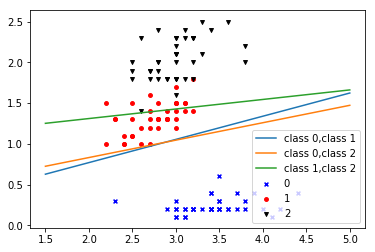

In [6]:
iris=load_iris()
feature=iris.data
target=iris.target
x=feature[:,[1,3]]
y=target[:]
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=31,stratify=y)
label = np.array(y_train)  
index_0 = np.where(label==0)  
plt.scatter(x_train[index_0,0],x_train[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x_train[index_1,0],x_train[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x_train[index_2,0],x_train[index_2,1],marker='v',color = 'k',label = '2',s = 15)  

gz=ganzhiqi()
vt=voter()
W=vt.train(x_train,y_train,1,gz)
pred=vt.predict(x_test)
acc=accuracy_score(y_test,pred)
print('the accuracy is: ',acc)
k=0
name=['class 0,class 1','class 0,class 2','class 1,class 2']
#show the decision boundary
for w in W:
    x1 = np.arange(1.5,5.5,0.5)  
    x2 = -( w[0] +w[1]*x1) / w[2]  
    plt.plot(x1,x2,label=name[k])   
    plt.legend(loc = 'best')  
    k=k+1
plt.show()  

using ovo mode for predicting


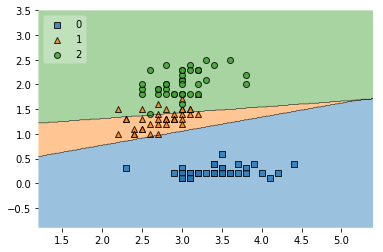

In [7]:
fig = plot_decision_regions(X=x_train, y=y_train,
                                clf=vt, legend=2)

training use ovr vote
no wrong sample break
[array([-0.09554775,  0.22811744, -1.03261241]), array([ 3.57046751, -1.4326952 , -0.03131017]), array([-3.15961306, -1.38189851,  4.06074457])]
using ovr mode for predicting
the accuracy is:  0.6666666666666666


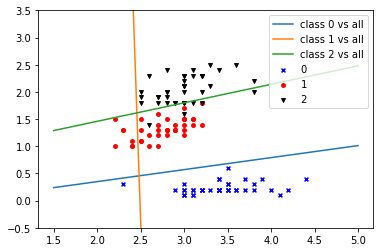

In [8]:
label = np.array(y_train)  
index_0 = np.where(label==0)  
plt.scatter(x_train[index_0,0],x_train[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x_train[index_1,0],x_train[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x_train[index_2,0],x_train[index_2,1],marker='v',color = 'k',label = '2',s = 15)  

gz=ganzhiqi()
vt=voter()
W=vt.train(x_train,y_train,0,gz)
print(W)
pred=vt.predict(x_test)
acc=accuracy_score(y_test,pred)
print('the accuracy is: ',acc)
k=0
name=['class 0 vs all','class 1 vs all','class 2 vs all']
#show the decision boundary
for w in W:
    x1 = np.arange(1.5,5.5,0.5)
    x2 = -( w[0] +w[1]*x1) / w[2]
    plt.ylim(ymax=3.5)
    plt.ylim(ymin=-0.5)
    plt.plot(x1,x2,label=name[k])   
    plt.legend(loc = 'best')  
    k=k+1
plt.show()  

using ovr mode for predicting


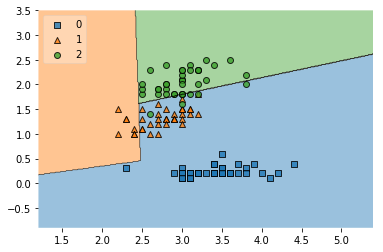

In [9]:
fig = plot_decision_regions(X=x_train, y=y_train,
                                clf=vt, legend=2)